# Lab 7 - Charles Voigt

In [1]:
#Housekeeping
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM) 

from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns

from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import warnings
warnings.filterwarnings('ignore')  # To ignore some convergence warnings from pygam


In [2]:
#Question 1
Auto = load_data('Auto')
y = Auto['mpg']
X = Auto[['horsepower']]

models = [MS([poly('horsepower', degree=d)]) 
          for d in range(1, 6)] 
Xs = [model.fit_transform(Auto) for model in models] 
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs]) 

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,9385.915872,0.0,NaN,NaN,NaN
1,389.0,7442.029412,1.0,1943.886460,103.876722,8.878263e-22
2,388.0,7426.436007,1.0,15.593405,0.833275,3.618941e-01
3,387.0,7399.522632,1.0,26.913375,1.438187,2.311666e-01
4,386.0,7223.371686,1.0,176.150946,9.413092,2.306428e-03


#### Question 1 Discussion

The ANOVA comparison shows that the quartic (degree 4) model is the most statistically justified. Compared to the cubic model, the F statistic is 1.438187, and the p-value is 0.231666.

In [3]:
# Question 2
Boston = load_data('Boston')
y = Boston['medv']
X = Boston[['lstat']]

bs_lstat = MS([bs('lstat',
                internal_knots=[10,20,30], intercept=True,
                name='bs(lstat)')]) 
Xbs = bs_lstat.fit_transform(Boston) 
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,18.7185,0.596,31.418,0.000
bs(lstat)[0],33.0135,1.754,18.820,0.000
bs(lstat)[1],8.3626,1.468,5.695,0.000
bs(lstat)[2],4.1366,1.447,2.858,0.004
bs(lstat)[3],-5.2037,1.649,-3.155,0.002
bs(lstat)[4],-8.2908,2.544,-3.259,0.001
bs(lstat)[5],-6.3724,3.916,-1.627,0.104
bs(lstat)[6],-6.9273,3.999,-1.732,0.084


In [4]:
print(f"R-squared: {M.rsquared:.4f}")

R-squared: 0.6835


#### Question 2 Discussion

The R squared of the B spline model is 0.6835, and it uses 7 basis functions.

In [5]:
#Question 3 
Hitters = load_data('Hitters').dropna()
y = Hitters['Salary']
X = Hitters[['Years']]
ns_years = MS([ns('Years', df=4, intercept=True,
                 name='ns(Years)')])
Xns = ns_years.fit_transform(Hitters)
M_ns = sm.OLS(y, Xns).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,384.8017,39.302,9.791,0.000
ns(Years)[0],143.7335,74.891,1.919,0.056
ns(Years)[1],821.0868,127.345,6.448,0.000
ns(Years)[2],-62.4347,38.643,-1.616,0.107
ns(Years)[3],27.7071,211.369,0.131,0.896


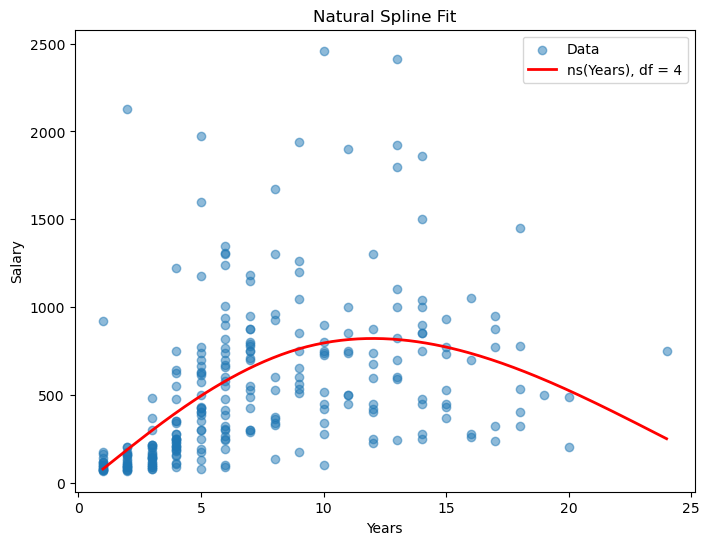

In [6]:
#Question 3 (continued)
# Create plot
fig, ax = subplots(figsize=(8, 6))
ax.scatter(Hitters['Years'], y, alpha=0.5, label='Data')

# Create prediction line
years_grid = np.linspace(Hitters['Years'].min(), 
                         Hitters['Years'].max(), 
                         200)
pred_df = pd.DataFrame({'Years': years_grid})
X_pred = ns_years.transform(pred_df)
y_pred = M_ns.predict(X_pred)

ax.plot(years_grid, y_pred, 'r-', linewidth=2, 
        label='ns(Years), df = 4')
ax.set_xlabel('Years')
ax.set_ylabel('Salary')
ax.set_title('Natural Spline Fit')
ax.legend()

In [7]:
#Question 3 (continued)
print(f"R-squared: {M_ns.rsquared:.4f}")

R-squared: 0.2623


#### Question 3 Discussion

The R-squared of the model is 0.2623

In [8]:
#Question 4
College = load_data('College')
y = College['Outstate'].to_numpy()
X = College[['Room.Board', 'PhD']].to_numpy()
gam = LinearGAM(s_gam(0) + s_gam(1)).gridsearch(X, y)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Training R-squared: 0.4990


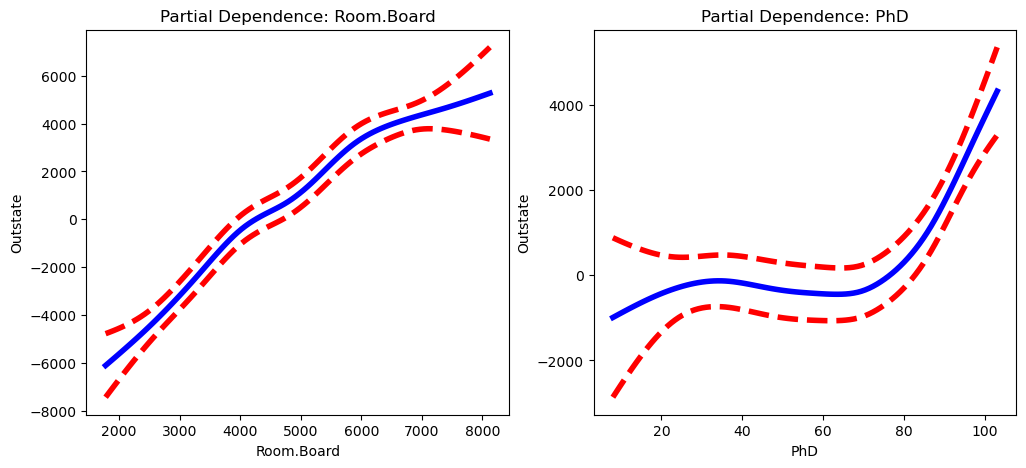

In [9]:
#Question 4 (continued)
fig, axs = subplots(1, 2, figsize=(12, 5))
plot_gam(gam, 0, ax=axs[0])
axs[0].set_title('Partial Dependence: Room.Board')
axs[0].set_xlabel('Room.Board')
axs[0].set_ylabel('Outstate')
plot_gam(gam, 1, ax=axs[1])

axs[1].set_title('Partial Dependence: PhD')
axs[1].set_xlabel('PhD')
axs[1].set_ylabel('Outstate')
# Training R-squared

train_r2 = gam.score(X, y)

print(f"Training R-squared: {train_r2:.4f}")


#### Question 4 Discussion

The training R squared is 0.4990

In [10]:
# Question 5
Carseats = load_data('Carseats')
y = Carseats['Sales']
Carseats['Bin'] = pd.cut(Carseats['Price'], bins=4, labels=False)

mask = Carseats['Bin'].notna()
Carseats = Carseats[mask]
y = y[mask]

x_bins = pd.get_dummies(Carseats['Bin'].astype(int), prefix='Bin')

x = sm.add_constant(x_bins).astype(float)
y = y.reset_index(drop=True)
x = x.reset_index(drop=True)

model = sm.OLS(y, x).fit()
print("Coefficient estimates:")
print(model.params)
print(f"\nR-squared: {model.rsquared:.4f}")

Coefficient estimates:
const    6.405560
Bin_0    4.554440
Bin_1    2.253145
Bin_2    0.547909
Bin_3   -0.949935
dtype: float64

R-squared: 0.1478


#### Question 5 Discussion 

The R squared of the model is 0.1478, and the 4th bin has the strongest negative effect on sales.